In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
%matplotlib inline

### Let's start by loading the Excel spreadsheets into pandas DataFrames. 

In [3]:
data_path = './data'
#act = pd.read_excel(f'{data_path}/ACT.xlsx')
#act_disag = pd.read_excel(f'{data_path}/ACT_DESAGREGADO.xlsx')
#adherence = pd.read_excel(f'{data_path}/Adherencia.xlsx')
familiar_records = pd.read_excel(f'{data_path}/Antecedentes_familiares.xlsx')
#pathological_records = pd.read_excel(f'{data_path}/Antecedentes_patologicos.xlsx')
#diagnostics_aids = pd.read_excel(f'{data_path}/Ayudas_diagnosticas.xlsx')
#biologics_asthma = pd.read_excel(f'{data_path}/Biologicos Asma.xlsx')
#life_quality = pd.read_excel(f'{data_path}/Calidad de vida relacioada en salud.xlsx')
#basic_info = pd.read_excel(f'{data_path}/Datos basicos.xlsx')
#dyspnea = pd.read_excel(f'{data_path}/Disnea.xlsx')
#ram_pharmacovigilance = pd.read_excel(f'{data_path}/Farmacovigilancia RAM.xlsx')
#habits = pd.read_excel(f'{data_path}/Habitos.xlsx')
#hospitalizations = pd.read_excel(f'{data_path}/Hospitalizaciones.xlsx')
#collecting_issues = pd.read_excel(f'{data_path}/Incosistencias en reclamacion.xlsx')
#medicines = pd.read_excel(f'{data_path}/Medicamentos.xlsx')
#height_weight = pd.read_excel(f'{data_path}/Mediciones de peso y talla.xlsx')
#emergencies = pd.read_excel(f'{data_path}/Urgencias.xlsx')
#vaccines = pd.read_excel(f'{data_path}/Vacunacion.xlsx')

### Family record

In [4]:
familiar_records.head()

,Id,EPS,FE_ALTA,FE_INICIO,FE_FIN,Diagnostico,CodDiagnostico,Parentesco
0,1998401,EPS/SURA,2012-07-09,2006-01-01,NaT,"ASMA, NO ESPECIFICADA",J459,MADRE
1,535255,EPS/SURA,2011-07-29,NaT,2011-07-29,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",E149,ABUELO
2,1004538,EPS/SURA,2012-01-17,2009-06-10,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE
3,788432,EPS/SURA,2012-01-06,2007-09-27,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE
4,788432,EPS/SURA,2012-01-06,2007-09-27,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE


In [5]:
familiar_records.columns = [col.lower() for col in familiar_records.columns]
familiar_records.rename(columns={
    'id': 'id_paciente',
    'fe_alta': 'fecha_alta',
    'fe_inicio': 'fecha_inicio',
    'fe_fin': 'fecha_fin',
    'coddiagnostico': 'cod_diagnostico'    
}, inplace=True)
familiar_records.head()

,id_paciente,eps,fecha_alta,fecha_inicio,fecha_fin,diagnostico,cod_diagnostico,parentesco
0,1998401,EPS/SURA,2012-07-09,2006-01-01,NaT,"ASMA, NO ESPECIFICADA",J459,MADRE
1,535255,EPS/SURA,2011-07-29,NaT,2011-07-29,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",E149,ABUELO
2,1004538,EPS/SURA,2012-01-17,2009-06-10,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE
3,788432,EPS/SURA,2012-01-06,2007-09-27,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE
4,788432,EPS/SURA,2012-01-06,2007-09-27,NaT,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE


In [6]:
familiar_records['id_paciente'].unique().size

53

In [7]:
familiar_records['eps'] = familiar_records['eps'].astype('category')
familiar_records['diagnostico'] = familiar_records['diagnostico'].astype('category')
familiar_records['cod_diagnostico'] = familiar_records['cod_diagnostico'].astype('category')
familiar_records['parentesco'] = familiar_records['parentesco'].astype('category')

In [8]:
familiar_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 8 columns):
id_paciente        104 non-null int64
eps                104 non-null category
fecha_alta         104 non-null datetime64[ns]
fecha_inicio       49 non-null datetime64[ns]
fecha_fin          27 non-null datetime64[ns]
diagnostico        104 non-null category
cod_diagnostico    104 non-null category
parentesco         104 non-null category
dtypes: category(4), datetime64[ns](3), int64(1)
memory usage: 7.0 KB


In [9]:
familiar_records.describe(include='all')

,id_paciente,eps,fecha_alta,fecha_inicio,fecha_fin,diagnostico,cod_diagnostico,parentesco
count,1.040000e+02,104,104,49,27,104,104,104
unique,NaN,2,50,34,13,32,32,6
top,NaN,EPS/SURA,2011-09-13 00:00:00,2009-06-11 00:00:00,2011-09-13 00:00:00,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE
freq,NaN,99,6,4,6,30,30,35
first,NaN,NaN,2010-12-01 00:00:00,1950-01-01 00:00:00,2010-12-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2019-06-19 00:00:00,2019-03-15 00:00:00,2011-10-11 00:00:00,NaN,NaN,NaN
mean,1.299300e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.405538e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.294100e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.967585e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
familiar_records.drop_duplicates(inplace=True)

In [11]:
familiar_records.groupby('parentesco').count().sort_values(by='id_paciente', ascending=False)

,id_paciente,eps,fecha_alta,fecha_inicio,fecha_fin,diagnostico,cod_diagnostico
parentesco,,,,,,,
MADRE,35,35,35,20,8,35,35
PADRE,33,33,33,15,5,33,33
HERMANO(A),20,20,20,6,8,20,20
ABUELA,8,8,8,3,3,8,8
ABUELO,4,4,4,3,3,4,4
FAMILIAR CERCANO,4,4,4,2,0,4,4


In [12]:
familiar_records.groupby('diagnostico').count().sort_values(by='id_paciente', ascending=False)

,id_paciente,eps,fecha_alta,fecha_inicio,fecha_fin,cod_diagnostico,parentesco
diagnostico,,,,,,,
HIPERTENSION ESENCIAL (PRIMARIA),30,30,30,17,5,30,30
"ASMA, NO ESPECIFICADA",26,26,26,15,4,26,26
"INFARTO AGUDO DEL MIOCARDIO, SIN OTRA ESPECIFICACION",5,5,5,2,4,5,5
DIABETES MELLITUS NO INSULINODEPENDIENTE SIN MENCION DE COMPLICACION,4,4,4,2,1,4,4
ASMA MIXTA,3,3,3,1,2,3,3
ASMA NO ALERGICA,3,3,3,0,1,3,3
"ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA",3,3,3,0,2,3,3
DIABETES INSIPIDA,3,3,3,1,1,3,3
"CARDIOMIOPATIA, NO ESPECIFICADA",2,2,2,1,0,2,2


,id_paciente,count
0,674247,7
1,1263349,5
2,1969148,4
3,1492864,4
4,788432,4


104


Text(0.5,1,'Number of family records per patient')

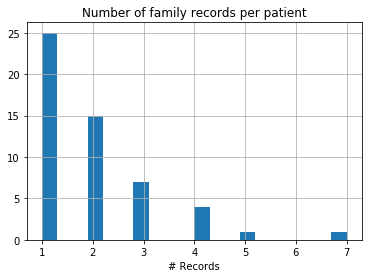

In [15]:
num_records_per_patient = familiar_records.groupby('id_paciente').size().sort_values(ascending=False).reset_index(name='count')
display(num_records_per_patient.head())
print(sum(num_records_per_patient['count']))
num_records_per_patient.hist('count', bins=20)
plt.xlabel('# Records')
plt.title('Number of family records per patient')

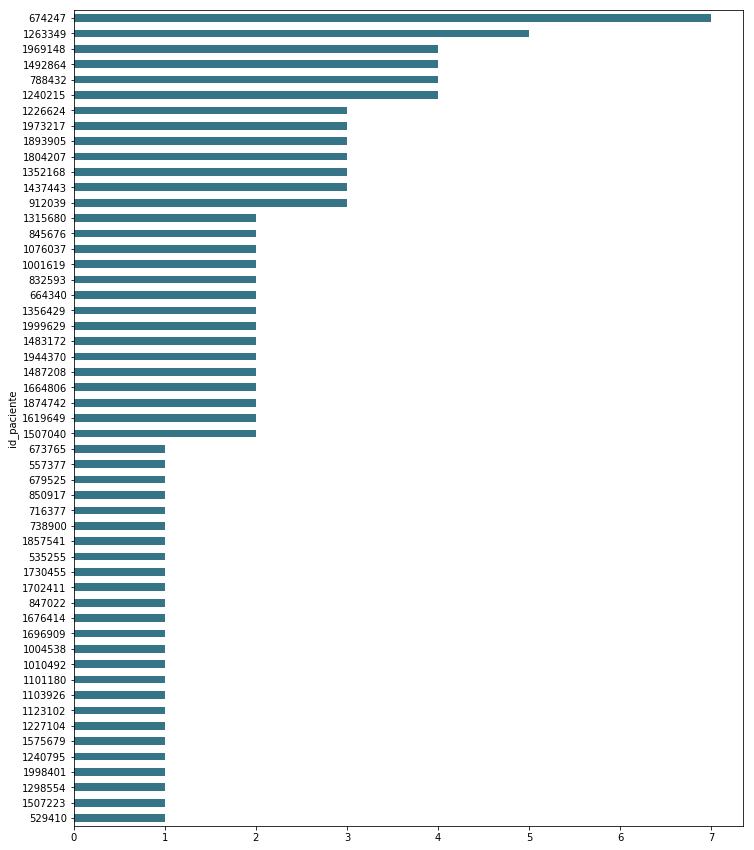

In [16]:
familiar_records.groupby('id_paciente').count().sort_values(by='eps', ascending=True)['eps'].plot(kind='barh', figsize=(12,15), color='#367588')

Text(0.5,0,'Year')

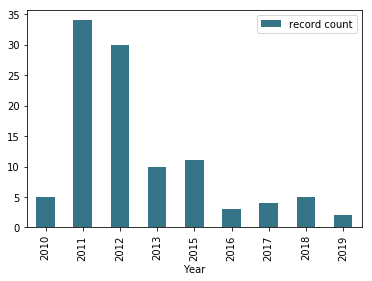

In [20]:
familiar_records['anio_alta'] = familiar_records['fecha_alta'].dt.year
ax = familiar_records[['anio_alta', 'diagnostico']].groupby('anio_alta').size().plot(kind='bar', color='#367588')
ax.legend(['record count'])
ax.set_xlabel('Year')

In [101]:
common_diagnosis = familiar_records[['id_paciente', 'diagnostico']].groupby('diagnostico').size().sort_values(ascending=True).reset_index(name='count')
common_diagnosis.head(10)

,diagnostico,count
0,ANEURISMA DE ARTERIA CORONARIA,1
1,"RINITIS ALERGICA, NO ESPECIFICADA",1
2,PARO RESPIRATORIO,1
3,OTRAS DIABETES MELLITUS ESPECIFICADAS SIN MENC...,1
4,"OSTEOPOROSIS POSTMENOPAUSICA, SIN FRACTURA PAT...",1
5,"OSTEOPOROSIS NO ESPECIFICADA, SIN FRACTURA PAT...",1
6,HISTORIA FAMILIAR DE TUMOR MALIGNO DE ORGANOS ...,1
7,"HIPOTIROIDISMO, NO ESPECIFICADO",1
8,"HIPERGLICEMIA, NO ESPECIFICADA",1
9,"ENFERMEDADES REUMATICAS DEL ENDOCARDIO, VALVUL...",1


Text(0.5,1,'Number of cases')

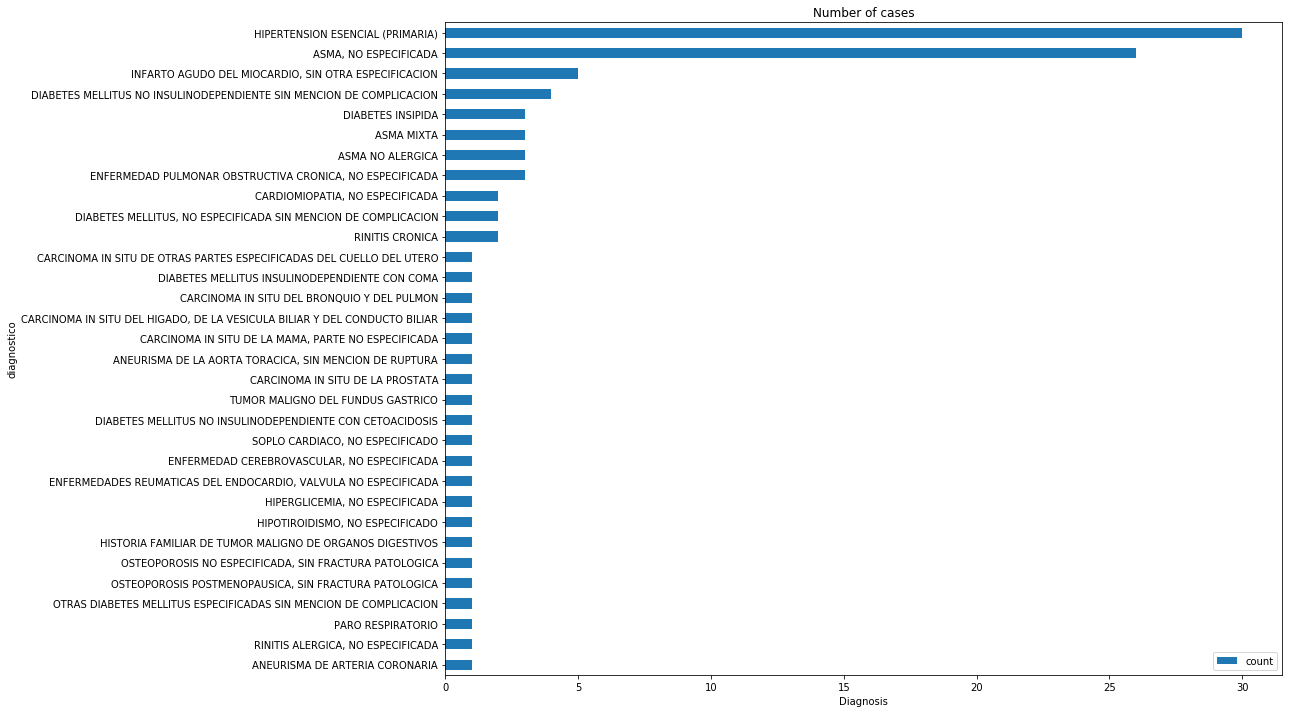

In [102]:
common_diagnosis.plot(kind='barh', x='diagnostico', figsize=(15,12))
plt.xlabel('Diagnosis')
plt.title('Number of cases')

In [105]:
common_relative = familiar_records[['id_paciente', 'parentesco']].groupby('parentesco').size().sort_values().reset_index(name='count')
common_relative.tail(10)

,parentesco,count
0,ABUELO,4
1,FAMILIAR CERCANO,4
2,ABUELA,8
3,HERMANO(A),20
4,PADRE,33
5,MADRE,35


Text(0.5,1,'Number of cases')

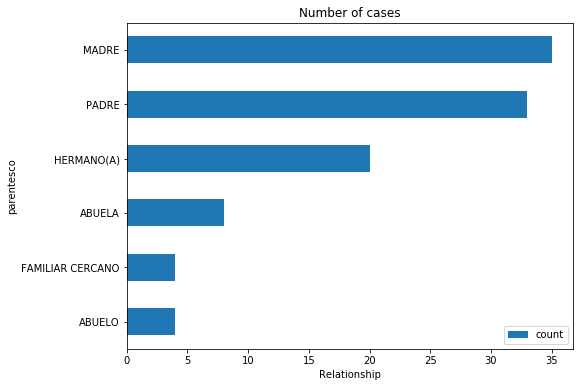

In [107]:
common_relative.plot(kind='barh', x='parentesco', figsize=(8,6))
plt.xlabel('Relationship')
plt.title('Number of cases')

In [112]:
familiar_records[(~(familiar_records['fecha_fin'].isna()))].shape

(27, 9)

In [113]:
familiar_records[(~familiar_records['fecha_inicio'].isna())].shape

(49, 9)

In [115]:
familiar_records[(~familiar_records['fecha_inicio'].isna()) & (~familiar_records['fecha_fin'].isna())]

,id_paciente,eps,fecha_alta,fecha_inicio,fecha_fin,diagnostico,cod_diagnostico,parentesco,anio_alta
9,1437443,EPS/SURA,2010-12-01,2010-12-01,2010-12-01,"ASMA, NO ESPECIFICADA",J459,MADRE,2010
10,1437443,EPS/SURA,2010-12-01,2010-12-01,2010-12-01,"ASMA, NO ESPECIFICADA",J459,HERMANO(A),2010
11,1437443,EPS/SURA,2010-12-01,2010-12-01,2010-12-01,"INFARTO AGUDO DEL MIOCARDIO, SIN OTRA ESPECIFI...",I219,ABUELO,2010
14,1999629,EPS/SURA,2010-12-02,2010-12-02,2010-12-02,"RINITIS ALERGICA, NO ESPECIFICADA",J304,HERMANO(A),2010
15,1999629,EPS/SURA,2010-12-02,2010-12-02,2010-12-02,"ASMA, NO ESPECIFICADA",J459,ABUELO,2010
22,1101180,EPS/SURA,2011-03-16,2000-05-31,2011-03-16,"ASMA, NO ESPECIFICADA",J459,HERMANO(A),2011
69,1944370,EPS/SURA,2011-07-12,2011-07-12,2011-07-12,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,2011


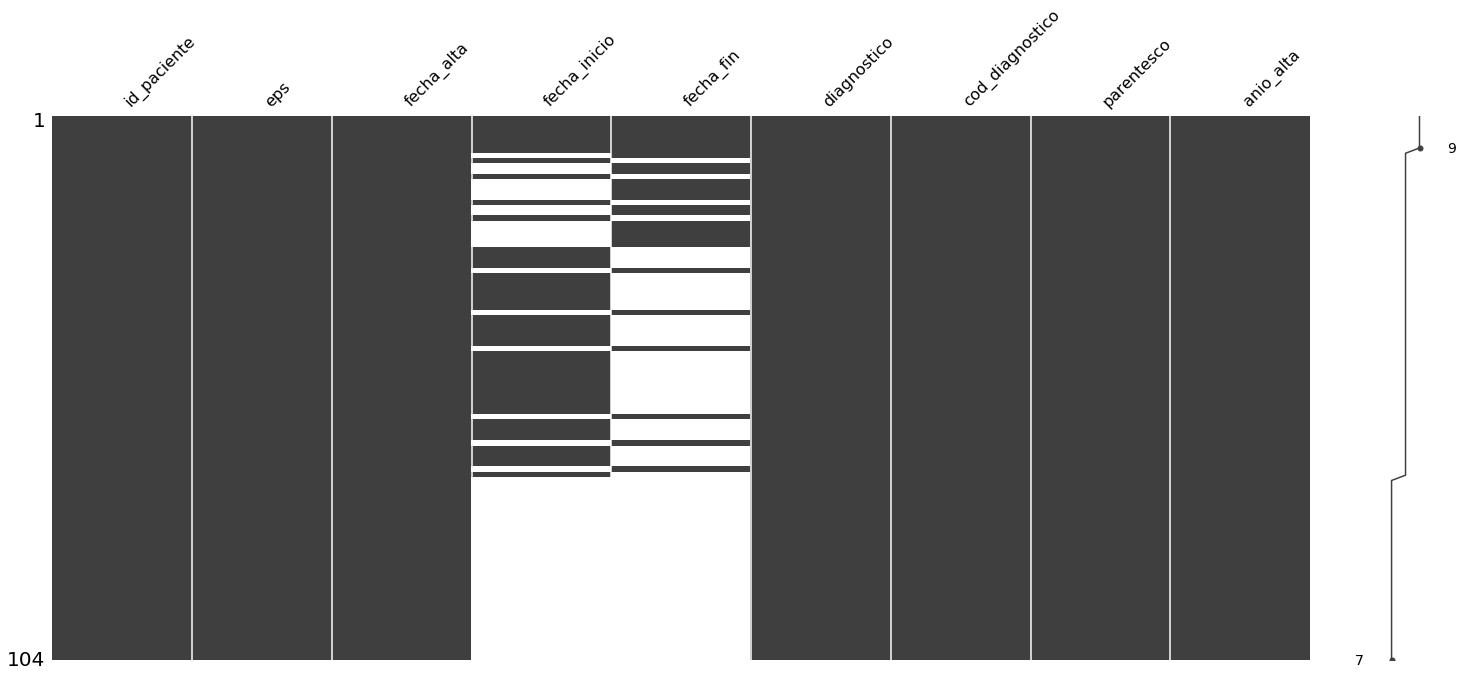

In [110]:
msno.matrix(msno.nullity_sort(familiar_records, sort='descending'))

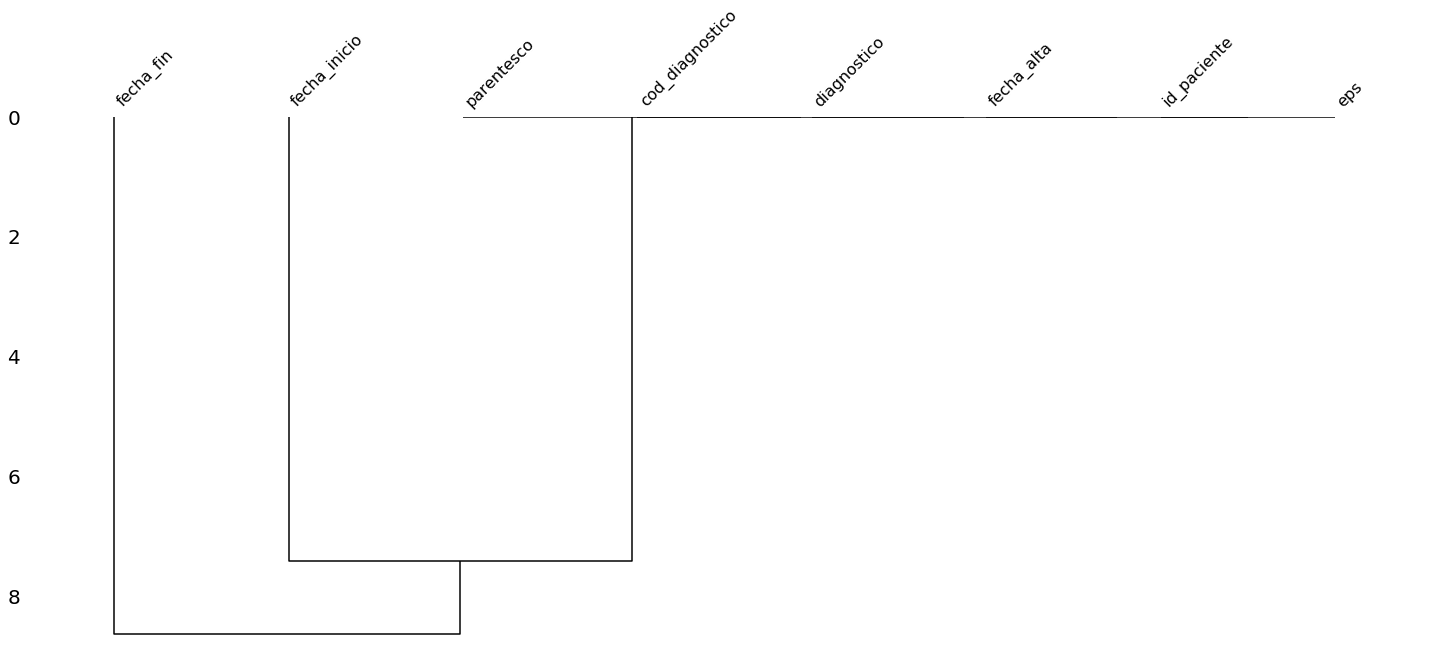

In [27]:
msno.dendrogram(familiar_records)

Both `start_date` (`fecha_inicio`) and `end_date` (`fecha_fin`) fields, have only been provided for 7 out of the 104 records. The `end_date` field has only been provided in 27 cases, while `start_date` only in 49 cases. Considering this we have opted for disposing of those columns:   

In [117]:
familiar_records.drop(columns=['fecha_inicio', 'fecha_fin'], inplace=True)

### Cleansed dataset:

In [120]:
familiar_records.describe(include='all')

,id_paciente,eps,fecha_alta,diagnostico,cod_diagnostico,parentesco,anio_alta
count,1.040000e+02,104,104,104,104,104,104.000000
unique,NaN,2,50,32,32,6,NaN
top,NaN,EPS/SURA,2011-09-13 00:00:00,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,NaN
freq,NaN,99,6,30,30,35,NaN
first,NaN,NaN,2010-12-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,2019-06-19 00:00:00,NaN,NaN,NaN,NaN
mean,1.299300e+06,NaN,NaN,NaN,NaN,NaN,2012.721154
std,4.405538e+05,NaN,NaN,NaN,NaN,NaN,2.278889
min,5.294100e+05,NaN,NaN,NaN,NaN,NaN,2010.000000
25%,8.967585e+05,NaN,NaN,NaN,NaN,NaN,2011.000000


In [121]:
familiar_records.to_csv('./data/cleansed/antecedentes_familiares.csv', sep='|')